In [67]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
from collections import defaultdict
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import log
import seaborn as sb
from sklearn import metrics as metrics
import os

In [186]:
def relDiff(c1, c2, DF, cutoff=0.01, verbose=False):
    import pandas as pd
    """
    Computes the relative difference between the values
    in columns c1 and c2 of DF.
    c1 and c2 are column names and DF is a Pandas data frame.
    Values less than cutoff will be treated as 0.
    The relative difference is defined as
    d(x_i, y_i) =
        0.0 if x_i and y_i are 0
        (x_i - y_i) / (|x_i + y_i|) otherwise
    This function returns two values.
    rd is a DataFrame where the "relDiff" column contains all
    of the computed relative differences.
    nz is a set of indexes into rd for data points where
    x_i and y_i were not *both* zero.
    """
    import numpy as np
    rd = pd.DataFrame(data = {"Name" : DF.index, "relDiff" : np.zeros(len(DF.index))*np.nan})
    rd.set_index("Name", inplace=True)
    bothZero = DF.loc[(DF[c1] < cutoff) & (DF[c2] < cutoff)].index
    nonZero = DF.index.difference(bothZero)
    if (verbose):
        print("Zero occurs in both columns {} times".format(len(rd.loc[bothZero])))
        print("Nonzero occurs in at least 1 column {} times".format(len(rd.loc[nonZero])))
    allRD = 2.0 * ((DF[c1] - DF[c2]) / (DF[c1] + DF[c2]).abs())
    assert(len(rd.loc[nonZero]["relDiff"]) == len(allRD[nonZero]))
    rd["relDiff"][nonZero] = allRD[nonZero]
    if len(bothZero) > 0:
        rd["relDiff"][bothZero] = 0.0
    return rd.fillna(0), nonZero

def L1(c1, c2, DF, cutoff=0.01, verbose=False):
    rd = pd.DataFrame(data = {"Name" : DF.index, "absDiff" : np.zeros(len(DF.index))*np.nan})
    rd.set_index("Name", inplace=True)
    bothZero = DF.loc[(DF[c1] < cutoff) & (DF[c2] < cutoff)].index
    nonZero = DF.index.difference(bothZero)
    allRD = abs(DF[c1] - DF[c2])
    assert(len(rd.loc[nonZero]["absDiff"]) == len(allRD[nonZero]))
    rd["absDiff"][nonZero] = allRD[nonZero]
    if len(bothZero) > 0:
        rd["absDiff"][bothZero] = 0.0
    return rd.fillna(0), nonZero

In [5]:
# around 40,000 taxids are duplicates!!!!
partyp = {}
repeated_ids = []
with open('/mnt/scratch2/cedar/input_files/nodes.dmp') as f:
    for line in f:
        sp = line.split("|")
        if int(sp[0].strip()) in partyp:
            repeated_ids += [int(sp[0].strip())]
        else:
            partyp[int(sp[0].strip())] = [int(sp[1].strip()), sp[2].strip()]
taxaTree = pd.DataFrame.from_dict(partyp, orient='index', columns=['parent_id', 'level'])
taxaTree=taxaTree.reset_index()
taxaTree.columns = ['tax_id','parent_id', 'level']

In [115]:
def aggregate(df, taxidID, cntID, level = 'species'):
    agg = {}
    notFoundCntr = 0
    notFoundMap = {}
    print('num rows: {}'.format(len(df)))
    for idx, row in df.iterrows():
        taxid = row[taxidID]
        cnt = row[cntID]
        if taxid in partyp:
            taxlevel = partyp[taxid][1]
#             print('next:{}'.format(taxlevel))
            while taxlevel != level and taxid != 1:
#                 print('{}:{}'.format(taxid, taxlevel))
                if taxid in partyp:    
                    taxid = partyp[taxid][0]
                    taxlevel = partyp[taxid][1]
                else:
                    if taxid not in notFoundMap:
                        notFoundMap[taxid] = 0
                        notFoundMap[taxid] += 1
                    print('{} in loop'.format(taxid))
                    notFoundCntr+=1
                    break
            if taxlevel == level:
                if taxid not in agg:
                     agg[taxid] = 0
                agg[taxid] += cnt
        else:
            if taxid not in notFoundMap:
                notFoundMap[taxid] = 0
            notFoundMap[taxid] += 1
            notFoundCntr+=1
    print('notFound: {}'.format(notFoundCntr))
    agg_df = pd.DataFrame.from_dict(agg, orient='index').reset_index()
    agg_df.columns = ['taxid', 'count']
    for k, v in notFoundMap.items():
        print('{}:{}'.format(k, v))
    return agg_df

In [89]:
seq2taxid[seq2taxid['ref'] == "M1|S1|C0"]

,ref,taxid
879802,M1|S1|C0,1169855


In [373]:
##### i100 dataset #####
seq2taxid=pd.read_table('/mnt/scratch2/cedar/input_files/seqid2taxid.map', header=None, names=['ref', 'taxid'])
seq2taxid['acc'] = seq2taxid['ref'].str.split('|').str[0]
truth=pd.read_table('/mnt/scratch2/cedar/input_files/i100_ref.truth')
truth_taxid = pd.merge(truth, seq2taxid, left_on='id', right_on='acc', how='left')
puff=pd.read_table('/mnt/scratch2/cedar/results/puff/aligned_trimmed_i100_31_sr1.quant/quant.sf')
sal=pd.read_table('/mnt/scratch2/cedar/results/salmon/aligned_trimmed_i100_31_sr1.salmon/quant.sf')
#cedar=pd.read_table('/mnt/scratch2/cedar/results/cedar/aligned_trimmed_i100_31_sr1_2.cedar')
cedar=pd.read_table('/mnt/scratch2/cedar/results/cedar/i100_setCoverOnNonUniq_mincut0.cedar')
bracken=pd.read_table('/mnt/scratch2/cedar/results/bracken/trimmed_i100_k31_bracken.kreport', header=None)

In [380]:
##### cami1 medium toy dataset #####
fullseq2taxidmap= pd.read_table('/mnt/scratch2/cedar/datasets/cami1/medium/225_genomes/M1_S001__insert_5000_gsa_mapping.tsv')
seq2taxid=fullseq2taxidmap[['#anonymous_gsa_id', 'tax_id']]
seq2taxid.columns = ['ref', 'taxid']
readmappings= pd.read_table('/mnt/scratch2/cedar/datasets/cami1/medium/225_genomes/M1_S001__insert_5000_gs_read_mapping.tsv')
readmappings['number_reads'] = 1
truth_taxid = (readmappings[['tax_id', 'number_reads']].groupby('tax_id').sum().reset_index())
truth_taxid.columns = ['taxid', 'cnt']
puff=pd.read_table('/mnt/scratch2/cedar/results/puff/cami_aligned_31_sr1.quant/quant.sf')
sal=pd.read_table('/mnt/scratch2/cedar/results/salmon/cami_aligned_31_sr1.salmon/quant.sf')
# cedar=pd.read_table('/mnt/scratch2/cedar/results/cedar/cami_aligned_31_sr1_2.cedar')
cedar=pd.read_table('/mnt/scratch2/cedar/results/cedar/cami_M1S1_setCoverOnNonUniq_mincut0.cedar')
bracken=pd.read_table('/mnt/scratch2/cedar/results/bracken/cami_M1S1_31_sr1_bracken.kreport', header=None)


In [394]:
cedar=pd.read_table('/mnt/scratch2/cedar/results/cedar/cami_M1S1_setCoverOnNonUniq_mincut0.cedar')


In [374]:
cedar=pd.read_table('/mnt/scratch2/cedar/results/cedar/i100_31_mohsen_align_newPuffer_trimmed_itThresholding_setCover2_segmentSize100_sr0.65.cedar')


In [370]:
fullseq2taxidmap= pd.read_table('/mnt/scratch2/cedar/datasets/cami1/medium/225_genomes/M1_S001__insert_5000_gsa_mapping.tsv')
seq2taxid=fullseq2taxidmap[['#anonymous_gsa_id', 'tax_id']]
seq2taxid.columns = ['ref', 'taxid']
readmappings= pd.read_table('/mnt/scratch2/cedar/datasets/cami1/medium/225_genomes/M1_S001__insert_5000_gs_read_mapping.tsv')
readmappings['number_reads'] = 1
truth_taxid = (readmappings[['tax_id', 'number_reads']].groupby('tax_id').sum().reset_index())


In [381]:
bracken.columns = ['percentage', 'count', 'distinctCount', 'level', 'taxid', 'taxname']
bracken = bracken[bracken['level'] == 'S'][['taxid', 'taxname', 'count']]
bracken['taxname'] = bracken['taxname'].str.strip()

In [382]:
puff_taxid = pd.merge(puff, seq2taxid, left_on='Name', right_on='ref', how='left')
sal_taxid = pd.merge(sal, seq2taxid, left_on='Name', right_on='ref', how='left')

In [383]:
print('true cnt: {}'.format(truth_taxid['cnt'].sum()))
print('pufferfish cnt: {}'.format(puff['NumReads'].sum()))
print('salmon cnt: {}'.format(sal['NumReads'].sum()))
print('cedar cnt: {}'.format(cedar['count'].sum()))
print('bracken cnt: {}'.format(bracken['count'].sum()))

true cnt: 3719013
pufferfish cnt: 3667501.439000001
salmon cnt: 1315746.9989999998
cedar cnt: 41224.584
bracken cnt: 1845039


In [395]:
# truth_agg = aggregate(truth_taxid, 'taxid', 'cnt')
# sal_agg = aggregate(sal_taxid, 'taxid', 'NumReads')
# puff_agg = aggregate(puff_taxid, 'taxid', 'NumReads')
cedar_agg = aggregate(cedar, 'taxaId', 'count')

num rows: 198
notFound: 0


In [109]:
readmappings[readmappings['tax_id'] == 1921421]

,#anonymous_read_id,genome_id,tax_id,sequence_id,number_reads


In [396]:
# Merging truth with prediction
trusal = pd.merge(truth_agg, sal_agg, on = 'taxid', how='outer', suffixes=['', '_sal']).fillna(0)
trusalpuf = pd.merge(trusal, puff_agg, on = 'taxid', how='outer', suffixes=['', '_puff']).fillna(0)
trusalpufced = pd.merge(trusalpuf, cedar_agg, on = 'taxid', how='outer', suffixes=['', '_cedar']).fillna(0)
trusalpufcedbrac = pd.merge(trusalpufced, bracken, on = 'taxid', how='outer', suffixes=['', '_brac']).fillna(0)

In [397]:
trusalpufcedbrac[['count', 'count_sal', 'count_puff', 'count_cedar', 'count_brac']].sum().astype(np.uint64)

count          3719011
count_sal      1315746
count_puff     3667499
count_cedar    3718267
count_brac     1845039
dtype: uint64

In [368]:
trusalpufcedbrac[['count', 'count_sal', 'count_puff', 'count_cedar', 'count_brac']].sum().astype(np.uint64)

count          26667004
count_sal      25836628
count_puff     26043627
count_cedar    26195019
count_brac     26321839
dtype: uint64

Text(0.5, 1.0, 'i100')

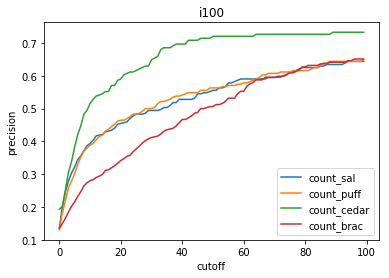

In [379]:
legends = ['count_sal', 'count_puff', 'count_cedar', 'count_brac']
for col in legends:
    precision = []
    recall = []    
    a = trusalpufcedbrac[(trusalpufcedbrac[col] > 0) | (trusalpufcedbrac['count'] != 0)]
    for minCnt in range(0,100):
        tp = len(a[(a[col] > minCnt) & (a['count'] > 0)])
        fp = len(a[(a[col] > minCnt) & (a['count'] == 0)])
        fn = len(a[(a[col] <= minCnt) & (a['count'] > 0)])
        precision += [tp / (tp + fp)]
        recall += [tp / (tp + fn)]
    #plt.plot(range(0, 100), recall)
    plt.plot(range(0, 100), precision)
plt.legend(legends, loc='lower right')
plt.ylabel("precision")
plt.xlabel("cutoff")
plt.title("i100")

Text(0.5, 1.0, 'cami')

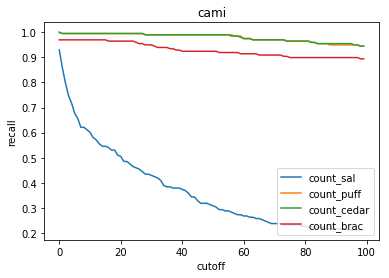

In [398]:
legends = ['count_sal', 'count_puff', 'count_cedar', 'count_brac']
for col in legends:
    precision = []
    recall = []    
    a = trusalpufcedbrac[(trusalpufcedbrac[col] > 0) | (trusalpufcedbrac['count'] != 0)]
    for minCnt in range(0,100):
        tp = len(a[(a[col] > minCnt) & (a['count'] > 0)])
        fp = len(a[(a[col] > minCnt) & (a['count'] == 0)])
        fn = len(a[(a[col] <= minCnt) & (a['count'] > 0)])
#         if col == 'count_cedar':
#             print('{},{},{}'.format(tp, fp, fn))
        precision += [tp / (tp + fp)]
        recall += [tp / (tp + fn)]
    #plt.plot(range(0, 100), recall)
    plt.plot(range(0, 100), recall)
plt.legend(legends, loc='lower right')
plt.ylabel("recall")
plt.xlabel("cutoff")
plt.title("cami")

In [333]:
minCnt = 0.01
res = []
for col in ['count_sal', 'count_puff', 'count_cedar', 'count_brac']:
    df = trusalpufcedbrac[(trusalpufcedbrac[col] > minCnt) | (trusalpufcedbrac['count'] != 0)]
    df[df[col] <= minCnt][col] = 0
    rd, _ = relDiff('count', col, df, cutoff=minCnt)
    rd1, _ = L1('count', col, df, cutoff=minCnt) 
    res += [[
        col, len(df), df[col].sum(),
        df[['count', col]].corr(method='spearman')['count'][col],
        metrics.explained_variance_score(df[col], df['count']),
        scipy.stats.kendalltau(df[col], df['count']).correlation,
        (0.5*rd['relDiff'].abs()).mean(),
        metrics.mean_absolute_error(df[col], df['count']),
        metrics.mean_squared_error(df[col], df['count']),
        metrics.mean_squared_log_error(df[col], df['count']),
        metrics.median_absolute_error(df[col], df['count']),
        rd1['absDiff'].sum(),
        scipy.spatial.distance.braycurtis(df[col], df['count']),
        scipy.spatial.distance.cosine(df[col], df['count']),
        scipy.spatial.distance.canberra(df[col], df['count'])
    ]]
final_metrics = pd.DataFrame.from_records(res, columns=['tool', '#rows', '#reads',
                                                       'sp', 'explained_var', 'Kendalltau',
                                                        'MARD',  
                                                        'MAE', 'MSE', 'MSLE', 'MedAE', 'L1',
                                                       'braycurtisDist', 'cosineDist', 'canberraDist'])
final_metrics = final_metrics.transpose()
final_metrics.columns = final_metrics.iloc[0]
final_metrics = final_metrics[1:]
final_metrics

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


tool,count_sal,count_puff,count_cedar,count_brac
#rows,578,615,440,624
#reads,2.58366e+07,2.60436e+07,2.6195e+07,2.63218e+07
sp,0.616015,0.59995,0.689061,0.582763
explained_var,0.998576,0.998486,0.999169,0.987125
Kendalltau,0.521763,0.507251,0.590932,0.500319
MARD,0.855516,0.863607,0.808927,0.867333
MAE,1717.88,1402.7,1494.49,1581.03
MSE,3.1233e+07,3.04511e+07,2.33653e+07,2.61196e+08
MSLE,5.70305,5.65402,5.4736,7.30803
MedAE,3.4545,3.797,5.00009,9


In [348]:
a = np.load('/home/fatemeh/others_projects/ditasic/similarity_matrix.npy')

In [349]:
a

array([[249871.]])

In [328]:
trusalpufcedbrac[(trusalpufcedbrac['count_cedar'] > minCnt)]

,taxid,count,count_sal,count_puff,count_cedar,taxname,count_brac
0,562,1493685.0,1430201.159,1406064.613,1.430560e+06,Escherichia coli,1481960.0
1,727,120507.0,114640.865,116610.975,1.169680e+05,Haemophilus influenzae,116880.0
2,83558,79974.0,78213.465,78142.175,7.863590e+04,Chlamydia pneumoniae,79090.0
3,782,73307.0,71813.471,71767.715,7.216460e+04,Rickettsia prowazekii,71893.0
4,1423,272560.0,263965.741,265027.262,2.656240e+05,Bacillus subtilis,269266.0
5,134821,48374.0,47346.000,47274.007,4.757350e+04,Ureaplasma parvum,45798.0
6,86665,274294.0,262720.352,267824.339,2.690430e+05,Bacillus halodurans,271726.0
7,1358,414349.0,393029.611,402925.997,4.048260e+05,Lactococcus lactis,407743.0
8,518,466134.0,450130.078,455432.643,4.577070e+05,Bordetella bronchiseptica,458333.0
9,35554,248267.0,241612.939,242379.657,2.439730e+05,Geobacter sulfurreducens,246125.0


In [ ]:
for minCnt in range(0, 100):
    print(minCnt)

In [100]:
minCnt = 0
res = []
for col in ['count_sal', 'count_puff', 'count_cedar', 'count_brac']:
    df = trusalpufcedbrac[(trusalpufcedbrac[col] > minCnt) | (trusalpufcedbrac['count'] != 0)]
    df[df[col] <= minCnt][col] = 0
    rd, _ = relDiff('count', col, df, cutoff=minCnt)
    res += [[
        col, len(df), df[col].sum(),
        df[['count', col]].corr(method='spearman')['count'][col],
        metrics.explained_variance_score(df[col], df['count']),
        scipy.stats.kendalltau(df[col], df['count']).correlation,
        (0.5*rd['relDiff'].abs()).mean(),
        metrics.mean_absolute_error(df[col], df['count']),
        metrics.mean_squared_error(df[col], df['count']),
        metrics.mean_squared_log_error(df[col], df['count']),
        metrics.median_absolute_error(df[col], df['count']),
        scipy.spatial.distance.braycurtis(df[col], df['count']),
        scipy.spatial.distance.cosine(df[col], df['count']),
        scipy.spatial.distance.canberra(df[col], df['count'])
    ]]
final_metrics = pd.DataFrame.from_records(res, columns=['tool', '#rows', '#reads',
                                                       'sp', 'explained_var', 'Kendalltau',
                                                        'MARD',  
                                                        'MAE', 'MSE', 'MSLE', 'MedAE',
                                                       'braycurtisDist', 'cosineDist', 'canberraDist'])
final_metrics = final_metrics.transpose()
final_metrics.columns = final_metrics.iloc[0]
final_metrics = final_metrics[1:]
final_metrics

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


tool,count_sal,count_puff,count_cedar,count_brac
#rows,197,197,197,197
#reads,1.31571e+06,3.66231e+06,3.7131e+06,1.84504e+06
sp,0.983664,0.996942,0.998035,0.959301
explained_var,0.586569,0.998667,0.999509,0.00541485
Kendalltau,0.903421,0.983345,0.986739,0.946392
MARD,0.938505,0.0134296,0.0108701,0.352377
MAE,12173.1,421.531,164.905,9486.17
MSE,6.14174e+08,2.47306e+06,935798,5.61102e+08
MSLE,23.9163,0.0209179,0.0125635,2.0001
MedAE,4421,1,2.2,2280


In [515]:
final_metrics['count_cedar']

#rows                     272
#reads            2.60648e+07
sp                    0.82132
explained_var        0.998164
Kendalltau           0.725386
MARD                  0.69163
MAE                   3227.83
MSE               7.61004e+07
MSLE                  10.6949
MedAE                 57.4371
braycurtisDist      0.0166497
cosineDist        0.000246832
canberraDist          188.123
Name: count_cedar, dtype: object

In [300]:
kraken=pd.read_table('/mnt/scratch2/cedar/results/bracken/i100_31.kraken', header=None)
kraken.columns = ['status', 'read', 'taxid', 'tmp', 'tmp2']
kraken = kraken[kraken['status'] == 'C'][['read', 'taxid']]
kraken['count'] = 1
kraken = kraken[['taxid', 'count']].groupby('taxid').sum().reset_index()
print(kraken['count'].sum())

247012


In [193]:
kraken_agg = aggregate(kraken, 'taxid', 'count')

notFound: 0


In [196]:
trukrak = pd.merge(truth_agg, kraken_agg, on = 'taxid', how='outer', suffixes=['', '_krak']).fillna(0)
col = 'count_krak'
print('{} ==> # of unique species: {}'.format(col, len(trukrak[trukrak[col] != 0])))
print('\tcorr: {}'.format(trukrak[(trukrak[col] != 0) | (trukrak['count'] != 0)]
                          [['count', col]].corr(method='spearman')['count'][col]))
rd, _ = relDiff('count', col, trukrak, cutoff=2)
print("\tMARD : {}".format((0.5*rd['relDiff'].abs()).mean()))

count_krak ==> # of unique species: 189
	corr: 0.9273881782943014
	MARD : 0.6429138449054718


In [286]:
col = 'count_cedar'
a = trusalpufcedbrac[(trusalpufcedbrac['count'] != 0) | (trusalpufcedbrac[col] > 0.001)][['taxid','count',col]]
a.sort_values(by='count', ascending=False, inplace=True)
a=a.reset_index()[['taxid','count', col]]

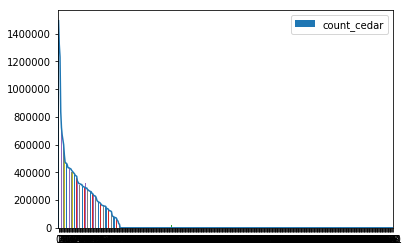

In [287]:
a.plot(kind='bar', y=col)
a['count'].plot()
plt.savefig('/mnt/scratch2/cedar/results/figs/i100_cedar_0.001.png')

In [234]:
trukrak['count_krak'].sum()

228964

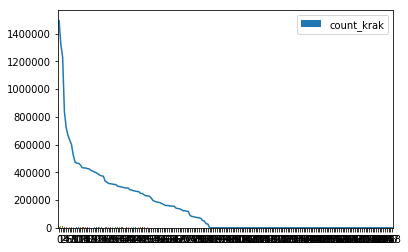

In [232]:
trukrak.sort_values(by='count', ascending=False, inplace=True)
b=trukrak.reset_index()[['taxid','count', 'count_krak']]
b.plot(kind='bar', y='count_krak')
b['count'].plot()

In [3]:
truth=pd.read_table('/mnt/scratch2/cedar/input_files/i100_taxonomy.truth')
truth = truth.groupby('Species').sum().reset_index()
print(truth.head(1))
puff=pd.read_table('/mnt/scratch2/cedar/results/script_results/noalnmnt_i100_31_sr1_puff/out.tab')
puff = puff.groupby('Species').sum().reset_index()
print(puff.head(1))
salmon=pd.read_table('/mnt/scratch2/cedar/results/script_results/i100_31_sr1_salmon/out.tab')
salmon = salmon.groupby('Species').sum().reset_index()
print(salmon.head(1))
cedar=pd.read_table('/mnt/scratch2/cedar/results/script_results/i100_31_sr1_cedar/out.tab')
cedar = cedar.groupby('Species').sum().reset_index()
print(cedar.head(1))

                   Species    TaxID  NumCounts
0  Acinetobacter baumannii  1018343   262164.0
             Species   TaxID  NumCounts
0  Absiella dolichum  428127      1.274
             Species   TaxID  NumCounts
0  Absiella dolichum  428127      1.005
             Species  TaxID  NumCounts
0  Absiella dolichum  31971      662.0


In [152]:
bracken=pd.read_table('/mnt/scratch2/cedar/results/bracken/i100_31.kreport_bracken', header=None)
bracken.columns = ['percentage', 'aggrCount', 'NumCounts', 'level', 'taxid', 'taxname']
bracken.head(1)
bracken = bracken[bracken['level'] == 'S'][['taxid', 'taxname', 'NumCounts']]
bracken['taxname'] = bracken['taxname'].str.strip()
bracken.columns = ['taxid', 'taxname', 'count']

In [149]:
truth=pd.read_table('/mnt/scratch2/cedar/input_files/i100_taxonomy.truth')
truth = truth.groupby('Species').sum().reset_index()


In [161]:
res = pd.merge(truth, bracken, left_on='Species', right_on='taxname', how='outer').fillna(0)

In [163]:
print('{} ==> # of unique species: {}'.format('bracken', len(res[res['Species'] != 0]['Species'].unique())))
print('\tcorr: {}'.format(res[['NumCounts', 'count']].corr(method='spearman')['NumCounts']['count']))
rd, _ = relDiff('NumCounts', 'count', res, cutoff=2)
print("\tMARD : {}".format((0.5*rd['relDiff'].abs()).mean()))

bracken ==> # of unique species: 85
	corr: 0.8808748841859805
	MARD : 0.6445672673488408


In [5]:
al=pd.merge(truth, puff, on='Species', how='outer')[['Species', 'NumCounts_x', 'NumCounts_y']].fillna(0)
al.columns = ['Species', 'truth', 'puff']
al=pd.merge(al, salmon, on='Species', how='outer')[['Species', 'truth', 'puff', 'NumCounts']].fillna(0)
al.columns = ['Species', 'truth', 'puff', 'salmon']
al=pd.merge(al, cedar, on='Species', how='outer')[['Species', 'truth', 'puff', 'salmon', 'NumCounts']].fillna(0)
al.columns = ['Species', 'truth', 'puff', 'salmon', 'cedar']
al=pd.merge(al, bracken, on='Species', how='outer')[['Species', 'truth', 'puff', 'salmon', 'cedar', 'NumCounts']].fillna(0)
al.columns = ['Species', 'truth', 'puff', 'salmon', 'cedar', 'bracken']

In [252]:
#26667004
pd.set_option('display.width', 500)
al[['truth', 'puff', 'salmon', 'cedar', 'bracken']].sum().astype(np.uint64)

truth      26667004
puff       26206795
salmon     25893411
cedar      26336914
bracken      246970
dtype: uint64

In [7]:
print('number of distinct species:')
for col in ['puff', 'salmon', 'cedar', 'bracken']:
    print('{} ==> # of unique species: {}'.format(col, len(al[al[col] != 0]['Species'].unique())))
    print('\tcorr: {}'.format(al[al[col] != 0][['truth', col]].corr(method='spearman')['truth'][col]))
    rd, _ = relDiff('truth', col, al, cutoff=2)
    print("\tMARD : {}".format((0.5*rd['relDiff'].abs()).mean()))

number of distinct species:
puff ==> # of unique species: 673
	corr: 0.5771148730419895
	MARD : 0.44326697994503655
salmon ==> # of unique species: 485
	corr: 0.6627743789409638
	MARD : 0.3759827143824895
cedar ==> # of unique species: 750
	corr: 0.5363935842728118
	MARD : 0.9442527780267141
bracken ==> # of unique species: 188
	corr: 0.9220709392084507
	MARD : 0.16307294380330192


In [22]:
al[al['salmon'] != 0]

,Species,truth,puff,salmon,cedar,bracken
0,Acinetobacter baumannii,262164.0,59875.158,243181.077,938622.0,2395.0
1,Alkalilimnicola ehrlichii,230160.0,52339.024,224504.034,56202.0,2234.0
2,Alkaliphilus metalliredigens,374667.0,85591.446,352826.229,109518.0,3465.0
3,Bacillus anthracis,408054.0,61818.911,394338.602,311929.0,3684.0
4,Bacillus cereus,1320777.0,248185.262,1271628.751,823304.0,12241.0
5,Bacillus clausii,286614.0,64841.676,280708.654,78647.0,2651.0
6,Bacillus halodurans,274294.0,63007.950,263758.940,93128.0,2512.0
7,Bacillus subtilis,272560.0,62709.799,265348.603,84908.0,2543.0
8,Bacillus thuringiensis,372187.0,161021.430,356551.975,374846.0,3272.0
9,Bacteroides thetaiotaomicron,402214.0,89738.833,384015.731,94806.0,3641.0


In [8]:
print('number of distinct shared species with truth:')
for col in ['puff', 'salmon', 'cedar', 'bracken']:
    print('{}: {}'.format(col, len(al[(al['truth'] != 0) & (al[col] != 0)]['Species'].unique())))

number of distinct shared species with truth:
puff: 85
salmon: 85
cedar: 85
bracken: 0


In [4]:
pufmap=pd.read_csv('/home/mohsen/pufferfish-test/out', sep='\t', header=None)
pufmap.columns = ['origread', 'puf']
pufmap['read'] = pufmap['origread'].str.split(';').str[0].str.split('/').str[1]

In [ ]:
salmap=pd.read_csv('/mnt/scratch4/mohsen/puffalign_test/out', sep='\t', header=None)
salmap.columns = ['origread', 'sal']
salmap['read'] = salmap['origread'].str.split(';').str[0].str.split('/').str[1]

In [ ]:
print(len(salmap))
print(len(pufmap))

In [ ]:
salmap.head(1)

In [58]:
print('Puff average hits over read: {}'.format(pufmap.groupby('read')['puf'].count().mean()))
print('Puff average hits over read and ref: {}'.format(pufmap.groupby(['read', 'puf'])['puf'].count().mean()))
print('Sal average hits over read: {}'.format(salmap.groupby('read')['sal'].count().mean()))
print('Sal average hits over read and ref: {}'.format(salmap.groupby(['read', 'sal'])['sal'].count().mean()))

Puff average hits over read: 1535.147682745575
Puff average hits over read and ref: 169.01331248918123
Sal average hits over read: 1524.5548226218552
Sal average hits over read and ref: 168.46238910425558


In [74]:
pufmap['count'] = 1
puf_uniqreadref = (pufmap.groupby(['read', 'puf'])['count'].count()).reset_index()
salmap['count'] = 1
sal_uniqreadref = (salmap.groupby(['read', 'sal'])['count'].count()).reset_index()

In [75]:
merged = pd.merge(sal_uniqreadref, puf_uniqreadref, left_on=['read', 'sal'], right_on=['read', 'puf'], how = 'outer').fillna(0)

In [76]:
len(merged)

740800

In [91]:
pufbetter=merged[(merged['count_x'] == 0) & (merged['read'] == merged['puf'])]
salbetter=merged[(merged['count_y'] == 0) & (merged['read'] == merged['sal'])]
pufworse=merged[(merged['count_x'] == 0) & (merged['read'] != merged['puf'])]
salworse=merged[(merged['count_y'] == 0) & (merged['read'] != merged['sal'])]

In [95]:
print('# of references found by puf but not sal: {}'.format(len(pufbetter)))
print('# of references found by sal but not puf: {}'.format(len(salbetter)))
print('# of invalid references found by puf but not sal: {}'.format(len(pufworse)))
print('# of invalid references found by sal but not puf: {}'.format(len(salworse)))
print('sum of valid hits found by puf but not sal: {}'.format(pufbetter['count_y'].sum()))
print('sum of invalid hits found by puf but not sal: {}'.format(pufworse['count_y'].sum()))
print('sum of valid hits found by sal but not puf: {}'.format(salbetter['count_x'].sum()))
print('sum of invalid hits found by sal but not puf: {}'.format(salworse['count_x'].sum()))

# of references found by puf but not sal: 164
# of references found by sal but not puf: 0
# of invalid references found by puf but not sal: 3908
# of invalid references found by sal but not puf: 1344
sum of valid hits found by puf but not sal: 52565.0
sum of invalid hits found by puf but not sal: 265940.0
sum of valid hits found by sal but not puf: 0
sum of invalid hits found by sal but not puf: 3677.0
